In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# CONUS
# aea_crs = ccrs.AlbersEqualArea(central_longitude=-96,
#                                standard_parallels=(29.5, 70),
#                                central_latitude=37.5,
#                                false_easting=0,
#                                false_northing=0)
# RUSSIA
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                               standard_parallels=(50, 70),
                               central_latitude=56,
                               false_easting=0,
                               false_northing=0)
# to proj4 form
aea_crs_proj4 = aea_crs.proj4_init

%matplotlib inline

from tqdm.notebook import tqdm

import geopandas as gpd
import numpy as np
from numpy import (arctan2, cos, sin, sqrt,
                    pi, append, diff)
from shapely.geometry import MultiPolygon
import pandas as pd
from pathlib import Path

plt.style.use('ggplot')

In [2]:
import pickle


with open('./data/RUSSIA/runs/era5_527_no_srad_1902_110025/train_data/train_data.p',
          "rb") as fp:
    results = pickle.load(fp)
    
results['data_vars'].keys()

dict_keys(['QObs', 'precip', 'temp_max', 'temp_min'])

In [3]:
import xarray as xr

test_xr = xr.Dataset.from_dict(results)

In [4]:
test_xr

<xarray.Dataset>
Dimensions:   (date: 3286, basin: 527)
Coordinates:
  * date      (date) datetime64[ns] 2007-01-02 2007-01-03 ... 2015-12-31
  * basin     (basin) <U5 '10042' '10044' '10048' ... '9560' '9563' '9568'
Data variables:
    QObs      (basin, date) float64 nan nan nan nan ... 0.4413 0.4335 0.4263
    precip    (basin, date) float64 nan nan nan nan ... 2.604 12.04 8.106 5.473
    temp_max  (basin, date) float64 nan nan nan nan ... -7.644 -7.128 -12.67
    temp_min  (basin, date) float64 nan nan nan nan ... -14.66 -12.74 -21.03

In [48]:
test_xr.sel({'basin': '10044'})

<xarray.Dataset>
Dimensions:   (date: 3286)
Coordinates:
  * date      (date) datetime64[ns] 2007-01-02 2007-01-03 ... 2015-12-31
    basin     <U5 '10044'
Data variables:
    QObs      (date) float64 nan nan nan nan nan ... 0.3069 0.3029 0.2989 0.2949
    precip    (date) float64 nan nan nan nan nan ... 4.38 12.02 7.848 17.17
    temp_max  (date) float64 nan nan nan nan nan ... -10.97 -9.284 -11.74 -14.61
    temp_min  (date) float64 nan nan nan nan nan ... -14.36 -15.52 -17.7 -19.12

### Spatial stuff


In [5]:
def polygon_area(lats, lons, radius=6378137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """

    lats, lons = np.deg2rad(lats), np.deg2rad(lons)
    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0] != lats[-1]:
        lats = append(lats, lats[0])
        lons = append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats) * sin(lons/2)**2
    colat = 2*arctan2(sqrt(a), sqrt(1-a))

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas = diff(colat)/2
    colat = colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate
    area = abs(sum(integrands))/(4*pi)

    area = min(area, 1-area)
    if radius is not None:  # return in units of radius
        return area * 4 * pi * radius**2 / 10**6
    else:  # return in ratio of sphere total area
        return area / 10**6


def select_big_from_MP(ws_geometry):
    """
    
    Function return only biggest polygon 
    from multipolygon WS
    It's the real WS, and not malfunctioned part of it
    
    """
    if type(ws_geometry) == MultiPolygon:
        big_area = [polygon_area(lats=polygon.exterior.coords.xy[1],
                                 lons=polygon.exterior.coords.xy[0])
                    for polygon in ws_geometry.geoms]
        ws_geometry = ws_geometry.geoms[np.argmax(big_area)]
    else:
        ws_geometry = ws_geometry
    return ws_geometry


## Select geom

### Russia geom

In [6]:
rus_data = Path('/workspaces/Tranfer_learning_LSTM/data/RUSSIA')

In [7]:
geometry_data = gpd.read_file(
    f'{rus_data}/openf_gauges_watersheds/watersheds_openf.shp')
geometry_data = geometry_data[['code', 'name_ru', 'name_en', 'geometry']]

geometry_data['geometry'] = [select_big_from_MP(ws)
                             for ws in geometry_data['geometry']]
geometry_data['centroids'] = [geom.centroid for geom
                              in geometry_data['geometry']]
geometry_data['code'] = [str(int(gauge)) for gauge in
                         geometry_data['code']]
geometry_data = geometry_data.rename(columns={'code': 'gauge_id'})
geometry_data = geometry_data.set_index('gauge_id')
# set basemap
basemap_data = gpd.read_file(
    f'{rus_data}/openf_gauges_watersheds/russia_forest_25people.geojson')
area_data = pd.read_pickle(f'{rus_data}/attributes/physio.pkl')


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### CONUS GEOM

In [3]:
geometry_data = gpd.read_file(
    './data/CAMELS/geometry_data/research_ws/HCDN_nhru_final_671.shp')
geometry_data['geometry'] = [select_big_from_MP(ws)
                             for ws in geometry_data['geometry']]
geometry_data['centroids'] = [geom.centroid for geom 
                              in geometry_data['geometry']]
geometry_data['hru_id'] = ['0' + str(gauge) if len(str(gauge)) != 8
                           else str(gauge)
                           for gauge in geometry_data['hru_id']]
geometry_data = geometry_data[['hru_id', 'centroids']]
geometry_data = geometry_data.rename(columns={'hru_id': 'gauge_id'})
geometry_data = geometry_data.set_index('gauge_id')
# select basemap
basemap_data = gpd.read_file(
    './data/CAMELS/geometry_data/basemap/cb_2018_us_state_500k.shp')
area_data = pd.read_pickle('./data/CAMELS/static/physio.pkl')

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [5]:
# test_ERA = pd.read_csv(
#     './data/CAMELS/runs/ERA_HydroATLAS_Every_531_0510_202838/test/model_epoch030/test_metrics.csv')
test_ERA = pd.read_csv(
    './data/CAMELS/runs/era5_527_no_srad_1902_110025/test/model_epoch030/test_metrics.csv')
test_ERA['basin'] = ['0' + str(gauge) if len(str(gauge)) != 8
                     else str(gauge)
                     for gauge in test_ERA['basin']]
test_ERA = test_ERA.rename(columns={'basin': 'gauge_id'})
test_ERA = test_ERA.set_index('gauge_id')

test_Maurer = pd.read_csv(
    './data/CAMELS/runs/Maurer_CAMELS_0811_063229/test/model_epoch030/test_metrics.csv')
test_Maurer['basin'] = ['0' + str(gauge) if len(str(gauge)) != 8
                        else str(gauge)
                        for gauge in test_Maurer['basin']]
test_Maurer = test_Maurer.rename(columns={'basin': 'gauge_id'})
test_Maurer = test_Maurer.set_index('gauge_id')


## Figures

In [10]:
figsize=(11.69,8.27)
rus_extent = [50, 140, 32, 90]

In [11]:
def create_gdf_for_plot(df: pd.DataFrame,
                        geom_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """[summary]

    Args:
        df ([type]): [description]
        geom_df ([type]): [description]

    Returns:
        [type]: [description]
    """
    pd.options.mode.chained_assignment = None
    df['geometry'] = geom_df['centroids']
    df = gpd.GeoDataFrame(df)

    return df

### Russia

#### ERA5 + HydroATLAS -- EALSTM -- blind test

In [24]:
blind_test = pd.read_csv(
    f'{rus_data}/runs/era5_test54_wstatic_1902_182418/test/model_epoch042/test_metrics.csv')

blind_test = blind_test.rename(columns={'basin': 'gauge_id'})
blind_test['gauge_id'] = [str(int(gauge)) for gauge in
                         blind_test['gauge_id']]
blind_test = blind_test.set_index('gauge_id')

blind_report = create_gdf_for_plot(df=geometry_data.join(blind_test).dropna(),
                                   geom_df=geometry_data).to_crs(aea_crs_proj4)

blind_report['NSE'][blind_report['NSE'] < 0] = 0
blind_report['KGE'][blind_report['KGE'] < 0] = 0


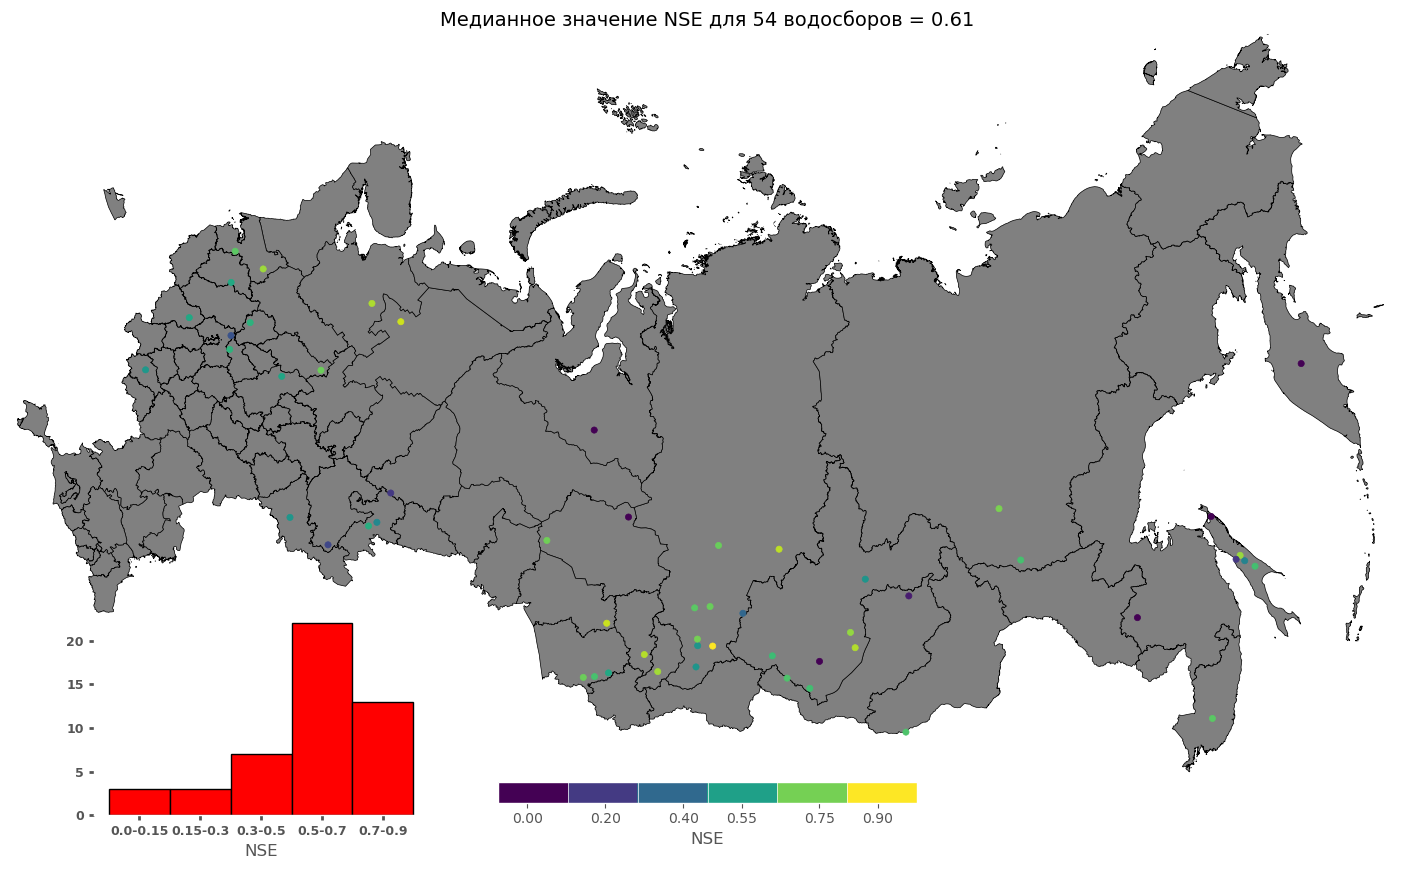

In [25]:
gdf_to_plot = blind_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(rus_extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.20, 0.40, 0.55, 0.75, 0.90],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
         fontsize=9,
         fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
         fontsize=9,
         fontweight="bold")

number_vars = len(blind_report)
nse_med = blind_report['NSE'].median()
plt.title(
    f'Медианное значение NSE для {len(blind_report)} водосборов = {nse_med:.2f}',
    fontdict={'size': 14})

plt.show()


#### ERA5 + HydroATLAS -- LSTM -- blind test

In [44]:
blind_test_lstm = pd.read_csv(
    f'{rus_data}/runs/blind_LSTM_ERA/test/model_epoch060/test_metrics.csv')

blind_test_lstm = blind_test_lstm.rename(columns={'basin': 'gauge_id'})
blind_test_lstm['gauge_id'] = [str(int(gauge)) for gauge in
                         blind_test_lstm['gauge_id']]
blind_test_lstm = blind_test_lstm.set_index('gauge_id')

blind_lstm_report = create_gdf_for_plot(df=geometry_data.join(blind_test_lstm).dropna(),
                                   geom_df=geometry_data).to_crs(aea_crs_proj4)

blind_lstm_report['NSE'][blind_lstm_report['NSE'] < 0] = 0
blind_lstm_report['KGE'][blind_lstm_report['KGE'] < 0] = 0

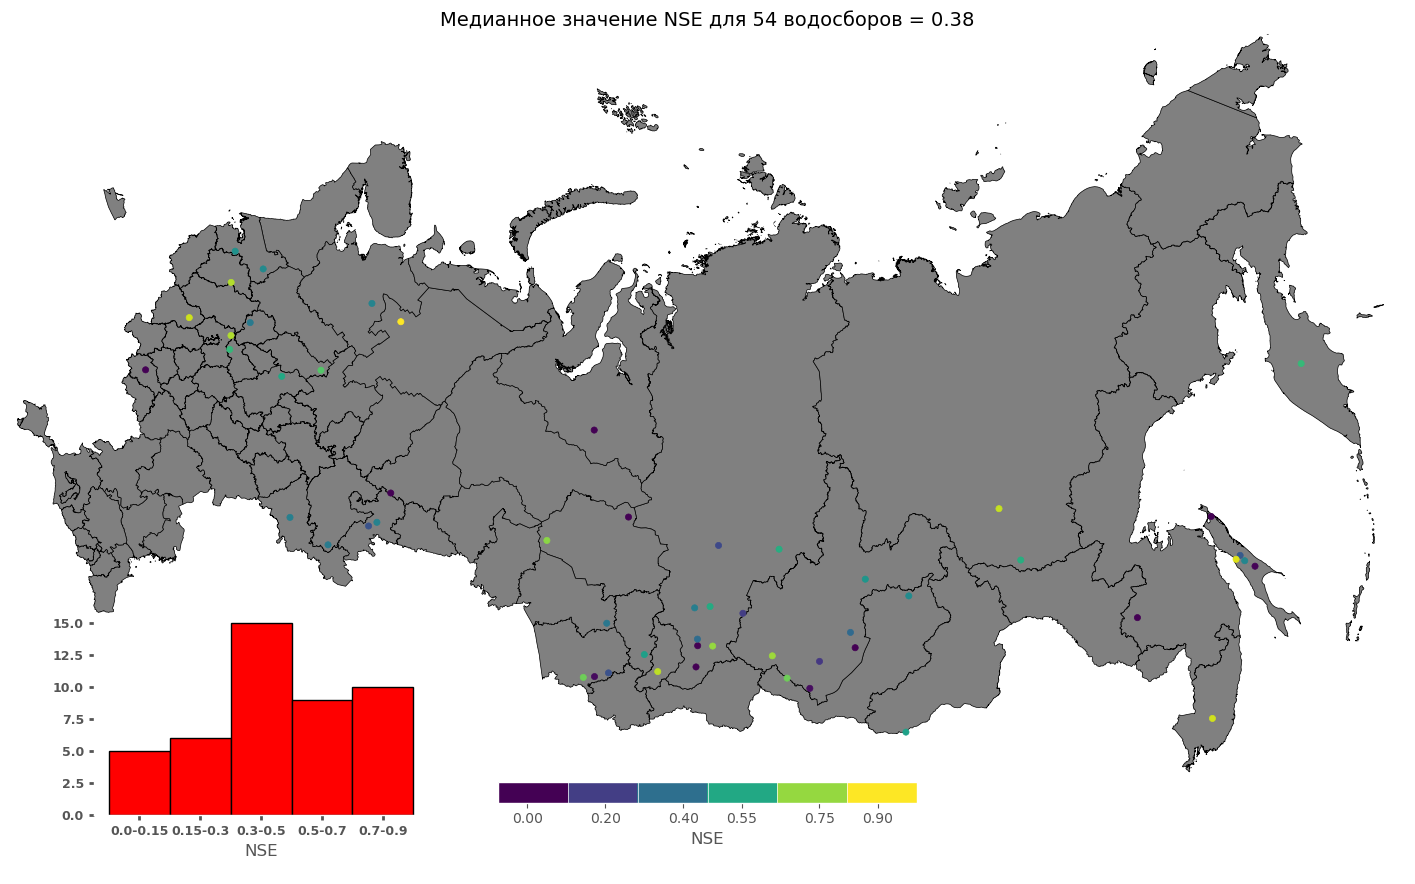

In [50]:
gdf_to_plot = blind_lstm_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(rus_extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.20, 0.40, 0.55, 0.75, 0.90],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
         fontsize=9,
         fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
         fontsize=9,
         fontweight="bold")

number_vars = len(blind_lstm_report)
nse_med = blind_lstm_report['NSE'].median()
plt.title(
    f'Медианное значение NSE для {len(blind_lstm_report)} водосборов = {nse_med:.2f}',
    fontdict={'size': 14})

plt.show()


#### ERA5 + HydroATLAS -- EALSTM -- Not touched period

In [52]:
ealstm = pd.read_csv(
    f'{rus_data}/runs/everything_EALSTM/test/model_epoch030/test_metrics.csv')

ealstm = ealstm.rename(columns={'basin': 'gauge_id'})
ealstm['gauge_id'] = [str(int(gauge)) for gauge in
                         ealstm['gauge_id']]
ealstm = ealstm.set_index('gauge_id')

ealstm_report = create_gdf_for_plot(df=geometry_data.join(ealstm).dropna(),
                                   geom_df=geometry_data).to_crs(aea_crs_proj4)

ealstm_report['NSE'][ealstm_report['NSE'] < 0] = 0
ealstm_report['KGE'][ealstm_report['KGE'] < 0] = 0

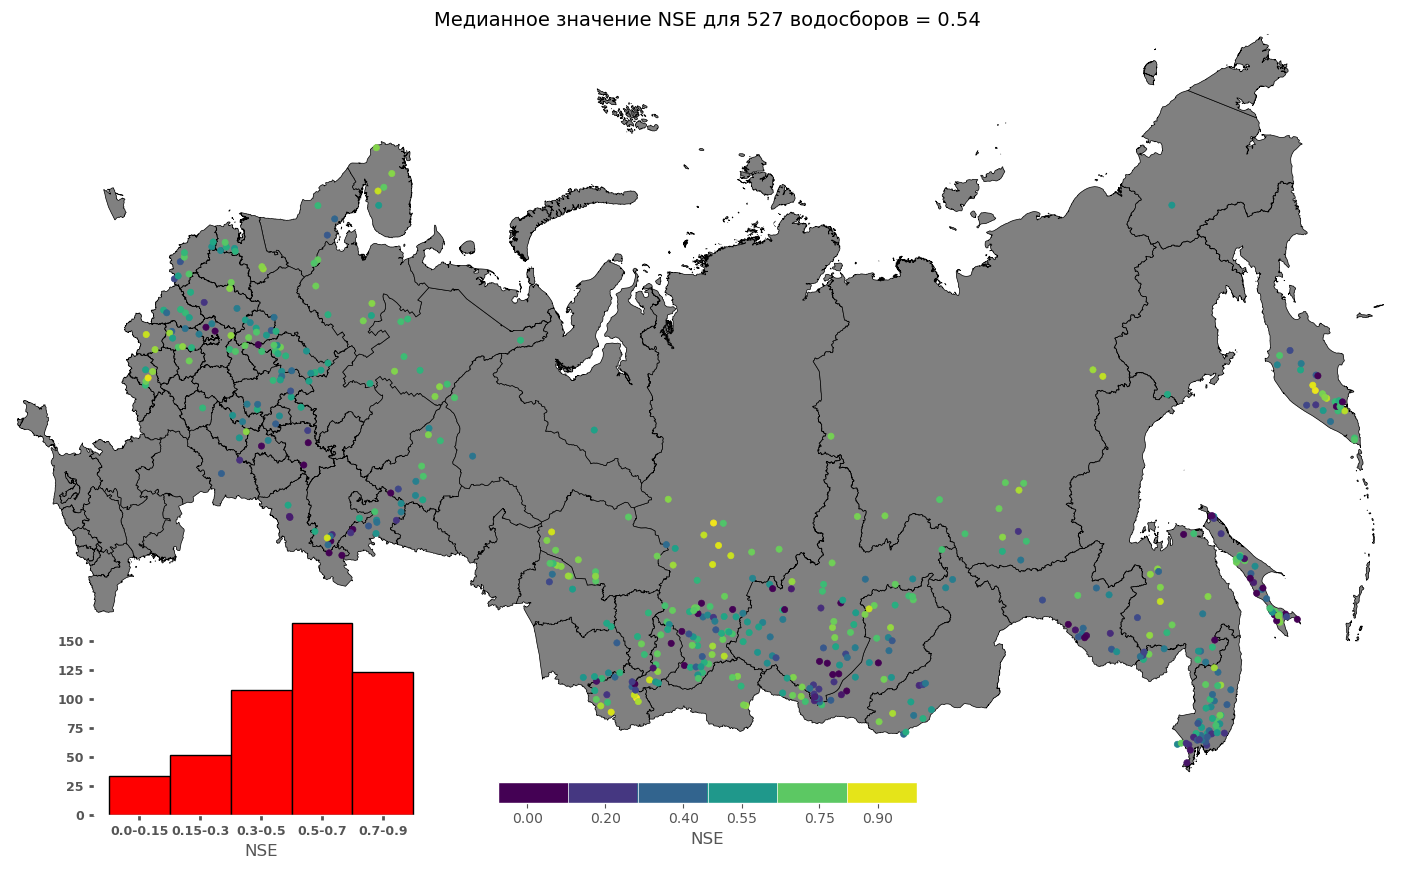

In [53]:
gdf_to_plot = ealstm_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(rus_extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.20, 0.40, 0.55, 0.75, 0.90],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
         fontsize=9,
         fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
         fontsize=9,
         fontweight="bold")

number_vars = len(ealstm_report)
nse_med = ealstm_report['NSE'].median()
plt.title(
    f'Медианное значение NSE для {len(ealstm_report)} водосборов = {nse_med:.2f}',
    fontdict={'size': 14})

plt.show()


#### ERA5 + HydroATLAS -- LSTM -- Not touched period

In [54]:
lstm = pd.read_csv(
    f'{rus_data}/runs/everything_LSTM/test/model_epoch030/test_metrics.csv')

lstm = lstm.rename(columns={'basin': 'gauge_id'})
lstm['gauge_id'] = [str(int(gauge)) for gauge in
                         lstm['gauge_id']]
lstm = lstm.set_index('gauge_id')

lstm_report = create_gdf_for_plot(df=geometry_data.join(lstm).dropna(),
                                   geom_df=geometry_data).to_crs(aea_crs_proj4)

lstm_report['NSE'][lstm_report['NSE'] < 0] = 0￼
lstm_report['KGE'][lstm_report['KGE'] < 0] = 0

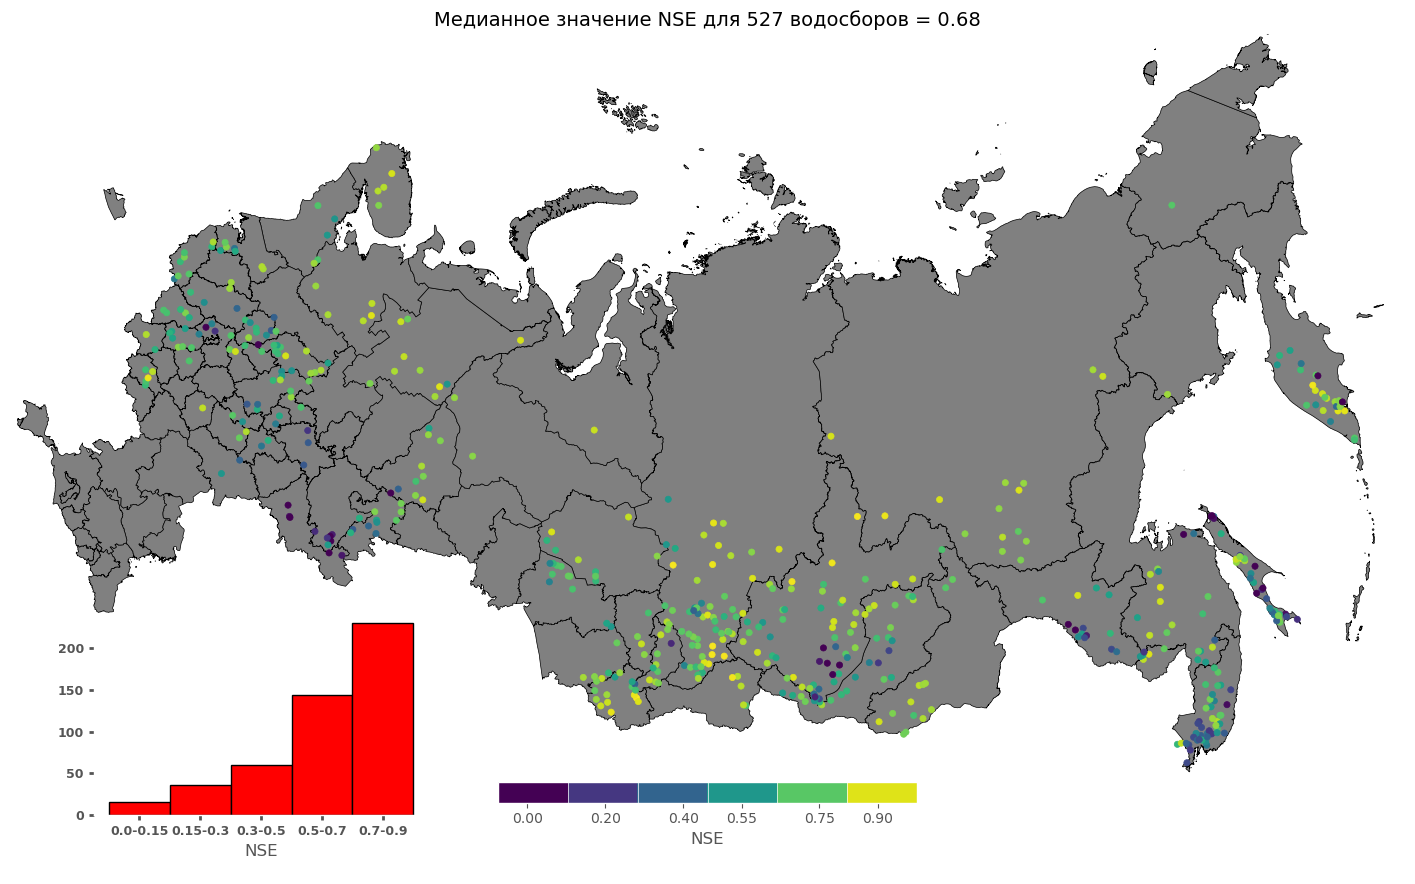

In [55]:
gdf_to_plot = lstm_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(rus_extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.20, 0.40, 0.55, 0.75, 0.90],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
         fontsize=9,
         fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
         fontsize=9,
         fontweight="bold")

number_vars = len(lstm_report)
nse_med = lstm_report['NSE'].median()
plt.title(
    f'Медианное значение NSE для {len(lstm_report)} водосборов = {nse_med:.2f}',
    fontdict={'size': 14})

plt.show()


#### New and old database

In [63]:
old_geom = create_gdf_for_plot(df=geometry_data,
                               geom_df=geometry_data).to_crs(aea_crs_proj4)

In [75]:
new_geom = gpd.read_file(
    f'{rus_data}/openf_gauges_watersheds/ws_16_01_23.gpkg')
new_geom = new_geom[['gauge_id', 'name', 'name_en', 'geometry']]
new_geom = new_geom.set_index('gauge_id')
new_geom['geometry'] = [select_big_from_MP(ws)
                        for ws in new_geom['geometry']]
new_geom['centroids'] = [geom.centroid for geom
                         in new_geom['geometry']]
new_geom = create_gdf_for_plot(df=new_geom,
                               geom_df=new_geom).to_crs(aea_crs_proj4)


/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


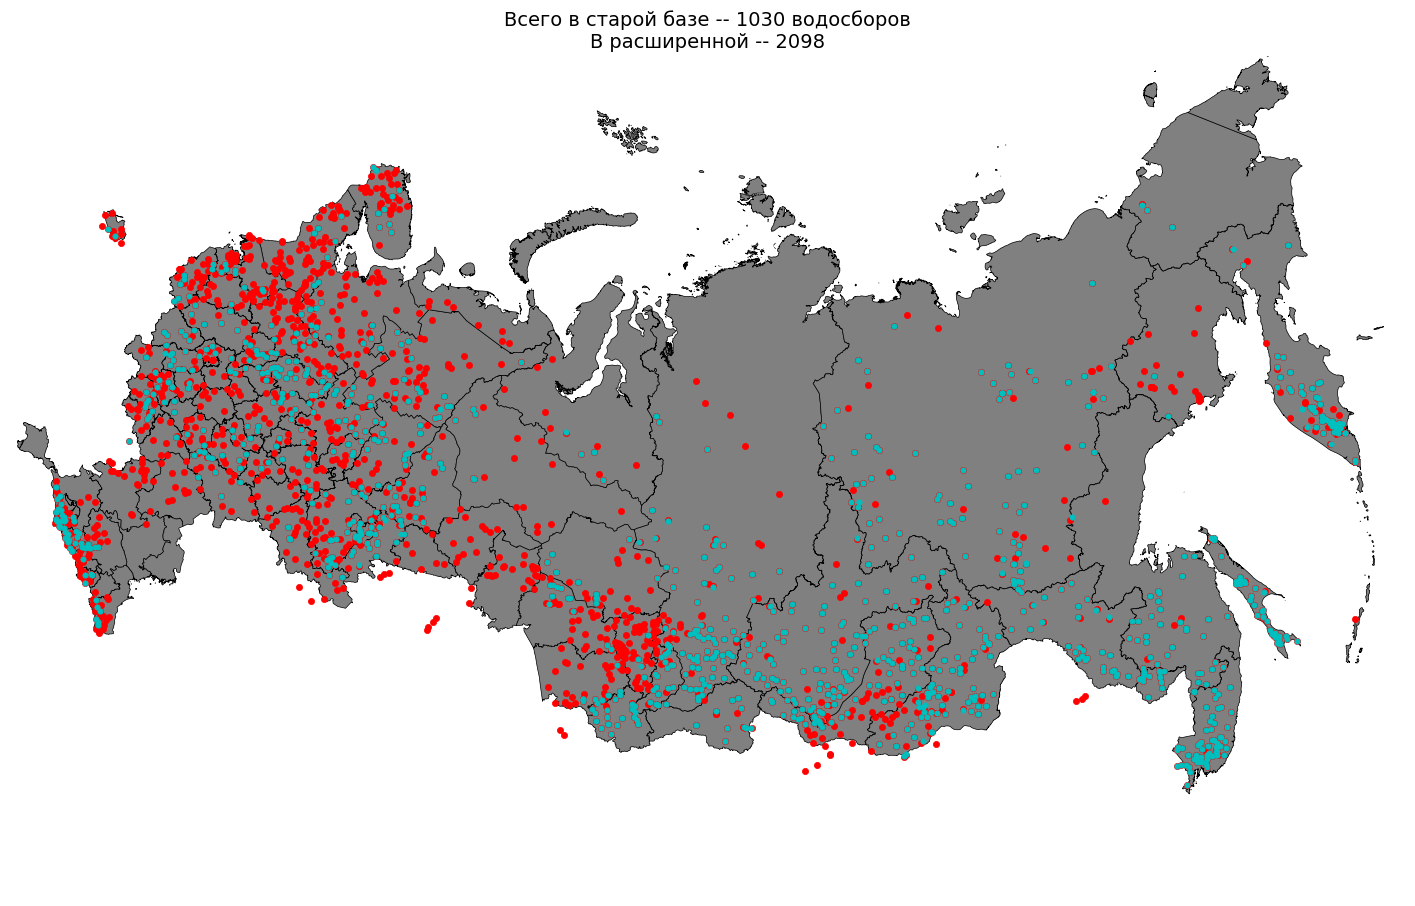

In [82]:
gdf_to_plot = old_geom

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(rus_extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot_new = new_geom.plot(
    ax=ax,
    marker='o', markersize=20, color='r',
    legend=False)
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    marker='o', markersize=15, color='c',
    legend=False)


plt.title(
    f'Всего в старой базе -- {len(gdf_to_plot)} водосборов\nВ расширенной -- {len(new_geom)}',
    fontdict={'size': 14});

In [ ]:


Maurer_report = create_gdf_for_plot(
    df=geometry_data.join(test_Maurer).dropna(),
    geom_df=geometry_data).set_crs(epsg=4326).to_crs(aea_crs_proj4)
Maurer_report = Maurer_report.join(area_data[['ws_area']])
Maurer_report['NSE'][Maurer_report['NSE'] < 0] = 0
Maurer_report['KGE'][Maurer_report['KGE'] < 0] = 0

Era_report = create_gdf_for_plot(
    df=geometry_data.join(test_ERA).dropna(),
    geom_df=geometry_data).set_crs(epsg=4326).to_crs(aea_crs_proj4)
Era_report = Era_report.join(area_data[['ws_area']])
Era_report['NSE'][Era_report['NSE'] < 0] = 0
Era_report['KGE'][Era_report['KGE'] < 0] = 0

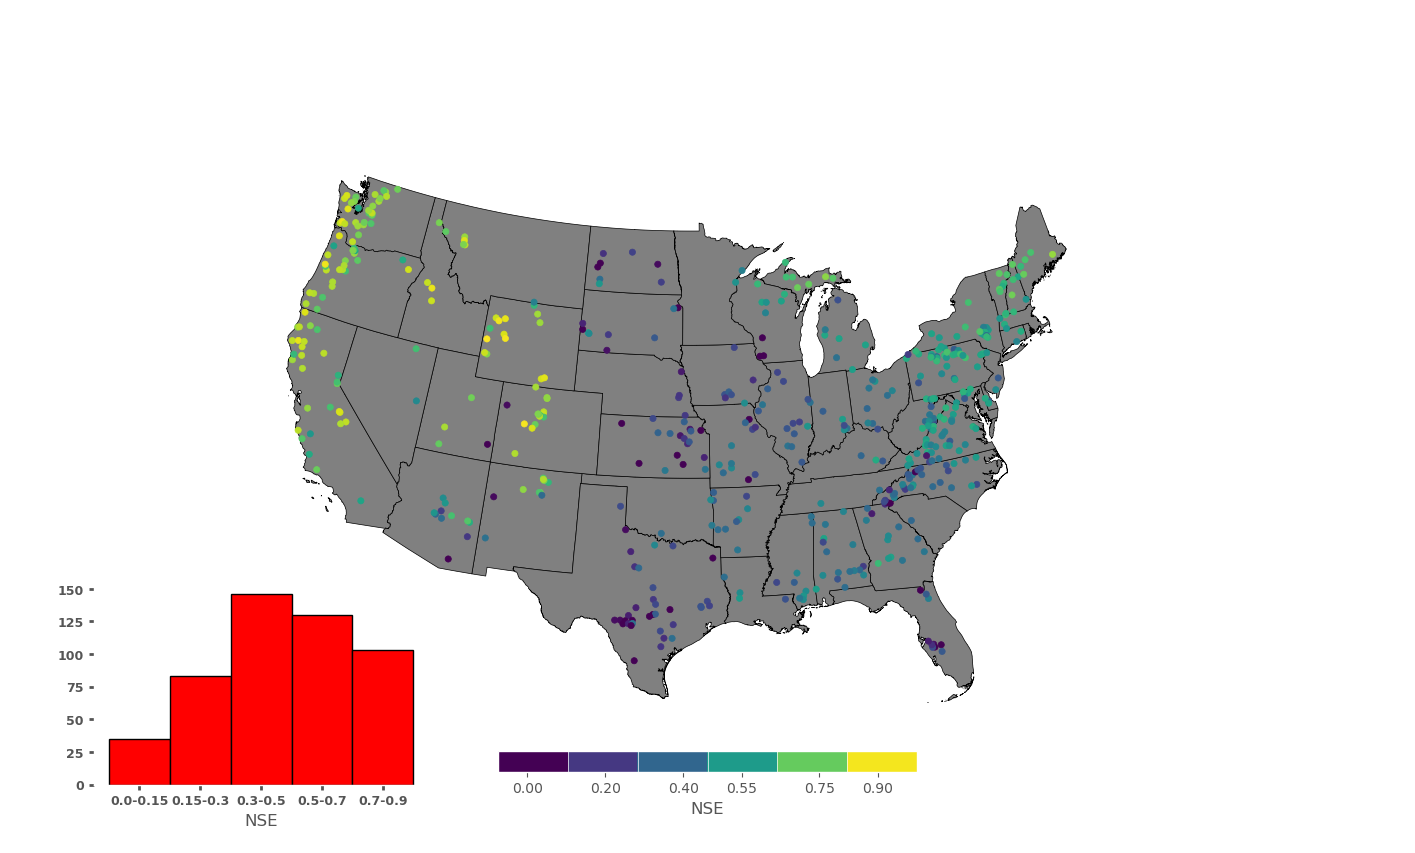

In [19]:
gdf_to_plot = Era_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.15, 0.30, 0.50, 0.70, 0.90]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})
extent = [-130, -60, 15, 55]

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.20, 0.40, 0.55, 0.75, 0.90],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
                            for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
            fontsize=9,
            fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
            fontsize=9,
            fontweight="bold")
plt.show()


In [ ]:
gdf_to_plot = Era_report

# list_of_limits = np.arange(vmin, vmax+1, 150)
# list_of_limits = [0, 250, 500, 1000, 2000]
list_of_limits = [0.00, 0.25, 0.40, 0.60, 0.75, 1.00]

fig, ax = plt.subplots(figsize=(18, 12),
                       subplot_kw={'projection': aea_crs})
extent = [-130, -60, 15, 55]

# plot settings
ax.set_aspect('equal')
ax.axis('off')
ax.set_extent(extent)
# Perm

# plot russia
basemap = basemap_data.to_crs(aea_crs_proj4).plot(
    ax=ax, color='grey', edgecolor='black', legend=False)

# plot variable
scatter_plot = gdf_to_plot.plot(
    ax=ax,
    column='NSE',
    marker='o', markersize=20,
    legend=True,
    legend_kwds={'label': 'NSE',
                 'orientation': 'horizontal',
                 'shrink': 0.3,
                 'pad': -0.1,
                 'values': list_of_limits,
                 'ticks': [0.00, 0.2, 0.4, 0.6, 0.8, 1.00],
                #  'labels': [],
                 'drawedges': True})

# list_of_limits_hist = [0, 250, 500, 1000, 2000]
hist_df = pd.crosstab(gdf_to_plot['NSE'],
                      pd.cut(gdf_to_plot['NSE'],
                             list_of_limits,
                             include_lowest=False))

hist_df = hist_df.reset_index(drop=True)

# x of borders, y of borders, weight, height
ax_hist = ax.inset_axes([0.06, 0.07, 0.24, 0.24])

extra_hist = hist_df.sum(axis=0).plot.bar(ax=ax_hist,
                                          rot=0,
                                          width=1,
                                          facecolor='red',
                                          edgecolor='black',
                                          lw=1)
extra_hist.set_facecolor('white')
extra_hist.tick_params(width=2)

xlbl = [str(col)[1:-1].replace(', ', '-')
                            for col in hist_df.columns]

extra_hist.set_xticklabels(xlbl)

plt.setp(ax_hist.get_xticklabels(),
            fontsize=9,
            fontweight="bold")
plt.setp(ax_hist.get_yticklabels(),
            fontsize=9,
            fontweight="bold")
plt.show()


### Meteo plots

In [6]:
from pathlib import Path
path_to_store = Path('./meteo_visualisations/')
path_to_store.mkdir(exist_ok=True, parents=True)
from typing import Tuple

def read_maurer(maurer_path: Path, basin: str) -> Tuple[pd.DataFrame, float]:
    """[summary]

    Args:
        basin (str): [description]

    Raises:
        RuntimeError: [description]

    Returns:
        Tuple[pd.DataFrame, float]: [description]
    """

    files = list(maurer_path.glob('**/*_forcing_leap.txt'))
    file_path = [f for f in files if f.name[:8] == basin]
    if len(file_path) == 0:
        raise RuntimeError(f'No file for Basin {basin} at {file_path}')
    else:
        file_path = file_path[0]

    df = pd.read_csv(file_path, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/" + df.Day.map(str))
    df['date'] = pd.to_datetime(dates, format="%Y-%m-%d")
    df = df.set_index('date', drop=True)

    # load area from header
    with open(file_path, 'r') as fp:
        content = fp.readlines()
        area = round(float(content[2]), 2)
        area /= 10**6

    return df, area


In [7]:
gauges = list(area_data.index)

In [8]:
differ_files = dict()

for gauge in tqdm(gauges):
    # read meteo file
    area = area_data.loc[gauge, 'ws_area']
    meteo_maurer, _ = read_maurer(maurer_path=Path(
        './data/CAMELS/basin_mean_forcing/maurer_extended'
    ),
        basin=gauge)
    meteo_era = pd.read_csv(f'./data/CAMELS/forcings/{gauge}.csv')
    meteo_era['date'] = pd.to_datetime(meteo_era['date'])
    meteo_era = meteo_era.set_index('date', drop=True)

    res_file = meteo_era.join(meteo_maurer)
    res_file = res_file['01/01/1980':'12/31/2008']
    res_file = res_file.rename(columns={'prcp(mm/day)': 'prcp',
                                        'srad(W/m2)': 'srad',
                                        'swe(mm)': 'swe',
                                        'tmax(C)': 'tmax',
                                        'tmin(C)': 'tmin',
                                        'vp(Pa)': 'vp'})

    differ_files[gauge] = res_file[['temp_max', 'tmax', 'temp_min',
                                    'tmin', 'precip', 'prcp']]


def get_mae_prcp(gauge):
    precip, prcp = differ_files[gauge][['precip', 'prcp']].groupby(
        pd.Grouper(freq='1Y')).sum().mean().values

    res = prcp - precip
    area = area_data.loc[gauge, 'ws_area']

    return (precip, prcp, area)


fin_res = pd.DataFrame()
for gauge, val in differ_files.items():

    era, maurer, area = get_mae_prcp(gauge)
    fin_res.loc[gauge, 'area'] = area
    fin_res.loc[gauge, 'prcp_Era'] = era
    fin_res.loc[gauge, 'prcp_Maurer'] = maurer

fin_res['area_gradation'] = pd.cut(fin_res['area'],
                                   bins=[0, 250, 500, 1000, 2000, np.inf],
                                   right=False,
                                   include_lowest=False)
# group_fin = fin_res.groupby('area_gradation').mean()
era_df = pd.DataFrame()
era_df = fin_res[['area', 'prcp_Era']]
era_df = era_df.rename(columns={'prcp_Era': 'prcp'})
era_df.loc[:, 'tag'] = 'ERA5'

maurer_df = pd.DataFrame()
maurer_df = fin_res[['area', 'prcp_Maurer']]
maurer_df.loc[:, 'tag'] = 'Maurer'
maurer_df = maurer_df.rename(columns={'prcp_Maurer': 'prcp'})

maurer_vs_era = pd.concat([era_df, maurer_df]).reset_index(drop=True)


A Jupyter Widget

/tmp/ipykernel_1198/88103196.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maurer_df.loc[:, 'tag'] = 'Maurer'


In [9]:
fin_res


,area,prcp_Era,prcp_Maurer,area_gradation
01013500,2302.903431,1131.943053,986.478621,"[2000.0, inf)"
01022500,620.423845,1146.762302,1207.854828,"[500.0, 1000.0)"
01030500,3675.502151,1128.475597,1085.230345,"[2000.0, inf)"
01031500,766.509220,1176.784675,1161.034483,"[500.0, 1000.0)"
01047000,904.969099,1178.680671,1152.266207,"[500.0, 1000.0)"
...,...,...,...,...
14309500,226.431942,1329.677149,1843.521724,"[0.0, 250.0)"
14316700,588.244890,1582.616854,1603.937931,"[500.0, 1000.0)"
14325000,445.160763,1489.699641,2585.008276,"[250.0, 500.0)"
14362250,43.907511,1022.074773,945.884828,"[0.0, 250.0)"


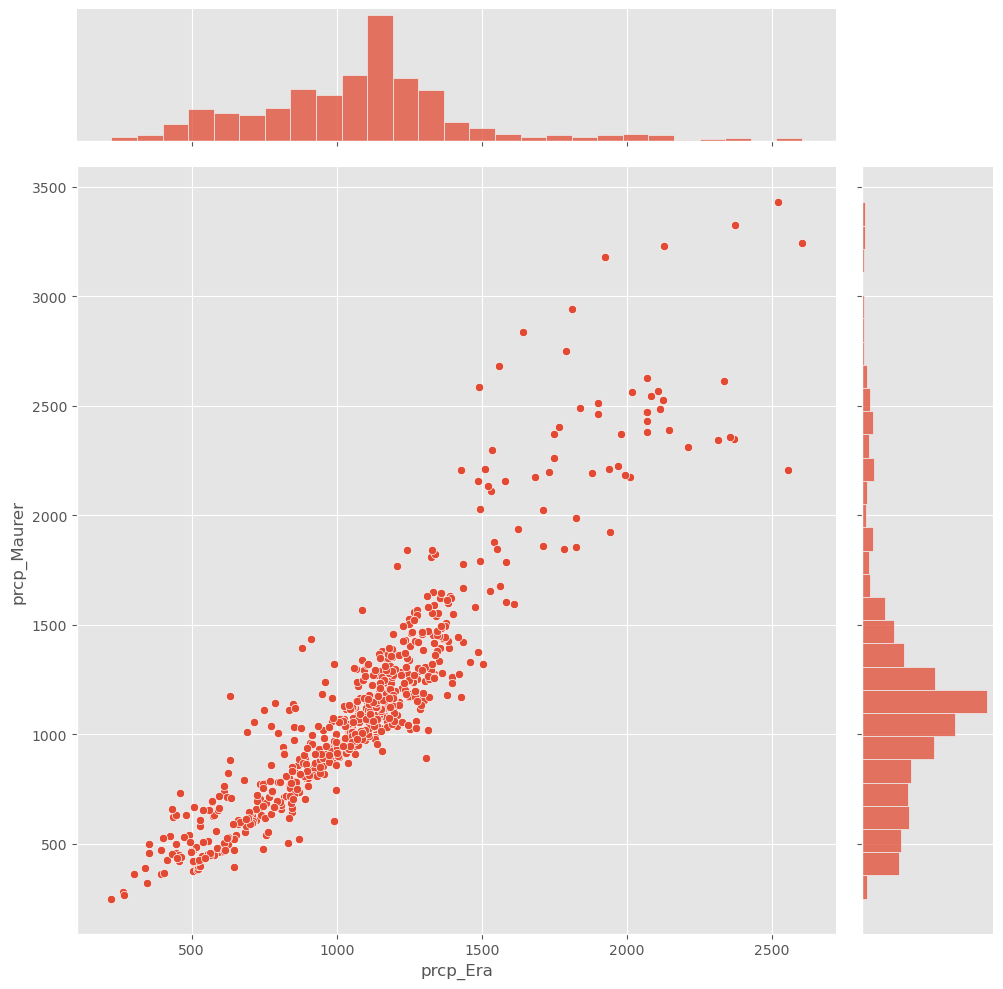

In [8]:
import seaborn as sns
sns.jointplot(data=fin_res, x="prcp_Era", y="prcp_Maurer", height=10);


In [35]:
my_hist

array([[<AxesSubplot:title={'center':'0.0-250.0, sq. km'}, xlabel='Annual precipitation difference, %', ylabel='Number of cases, pcs.'>,
        <AxesSubplot:title={'center':'250.0-500.0, sq. km'}, xlabel='Annual precipitation difference, %', ylabel='Number of cases, pcs.'>],
       [<AxesSubplot:title={'center':'500.0-1000.0, sq. km'}, xlabel='Annual precipitation difference, %', ylabel='Number of cases, pcs.'>,
        <AxesSubplot:title={'center':'1000.0-2000.0, sq. km'}, xlabel='Annual precipitation difference, %', ylabel='Number of cases, pcs.'>],
       [<AxesSubplot:title={'center':'2000.0-inf, sq. km'}, xlabel='Annual precipitation difference, %', ylabel='Number of cases, pcs.'>,
        <AxesSubplot:>]], dtype=object)

In [10]:
fin_res['prcp_diff'] = (fin_res['prcp_Maurer'] -
                        fin_res['prcp_Era'])/fin_res['prcp_Maurer'] * 100


In [16]:
fin_res.median()

/tmp/ipykernel_1198/546610392.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  fin_res.median()


area            340.584713
prcp_Era       1108.995339
prcp_Maurer    1091.709655
prcp_diff        -0.218670
dtype: float64

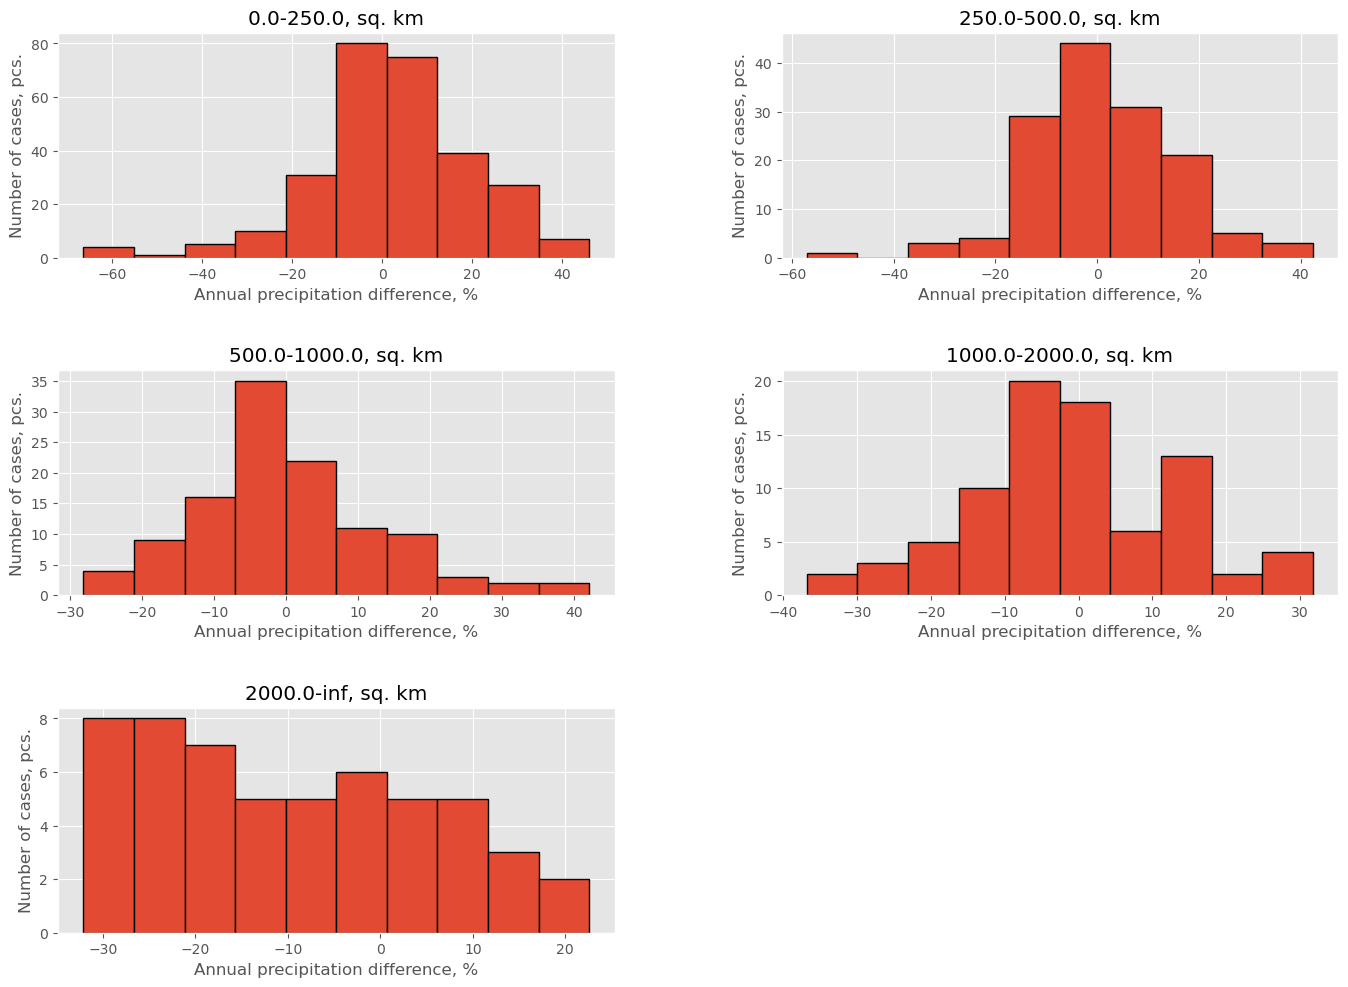

In [11]:

my_hist = fin_res.hist(column='prcp_diff',
                       by='area_gradation',
                       figsize=(16, 12),
                       edgecolor='black', linewidth=1)

xlbl = [str(col)[1:-1].replace(', ', '-')
        for col in np.unique(fin_res['area_gradation'])]
xlbl = [f'{lbl}, sq. km' for lbl in xlbl]

for i, ax in enumerate(my_hist.flatten()[:-1]):
    ax.set_title(xlbl[i])
    ax.set_xlabel("Annual precipitation difference, %")
    ax.set_ylabel('Number of cases, pcs.')
    ax.tick_params(axis='x', labelrotation=0);


In [11]:
from sklearn.metrics import r2_score


def get_r2(precip_df, frequency: str):
    precip_df = precip_df.groupby(pd.Grouper(freq=frequency)).sum()
    return r2_score(y_true=precip_df['prcp'],
                    y_pred=precip_df['precip'])


def value_hist(column_to_plot: str,
               frequency: str,
               xlabel: str):

    fin_res[column_to_plot] = [get_r2(data,
                                  frequency=frequency)
                           for data in differ_files.values()]

    my_hist = fin_res.hist(column=column_to_plot,
                           by='area_gradation',
                           figsize=(16, 12),
                           edgecolor='black', linewidth=1)

    xlbl = [str(col)[1:-1].replace(', ', '-')
            for col in np.unique(fin_res['area_gradation'])]
    xlbl = [f'{lbl}, кв. км' for lbl in xlbl]

    for i, ax in enumerate(my_hist.flatten()[:-1]):
        ax.set_title(xlbl[i])
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Число объектов, шт.')
        ax.tick_params(axis='x', labelrotation=0)


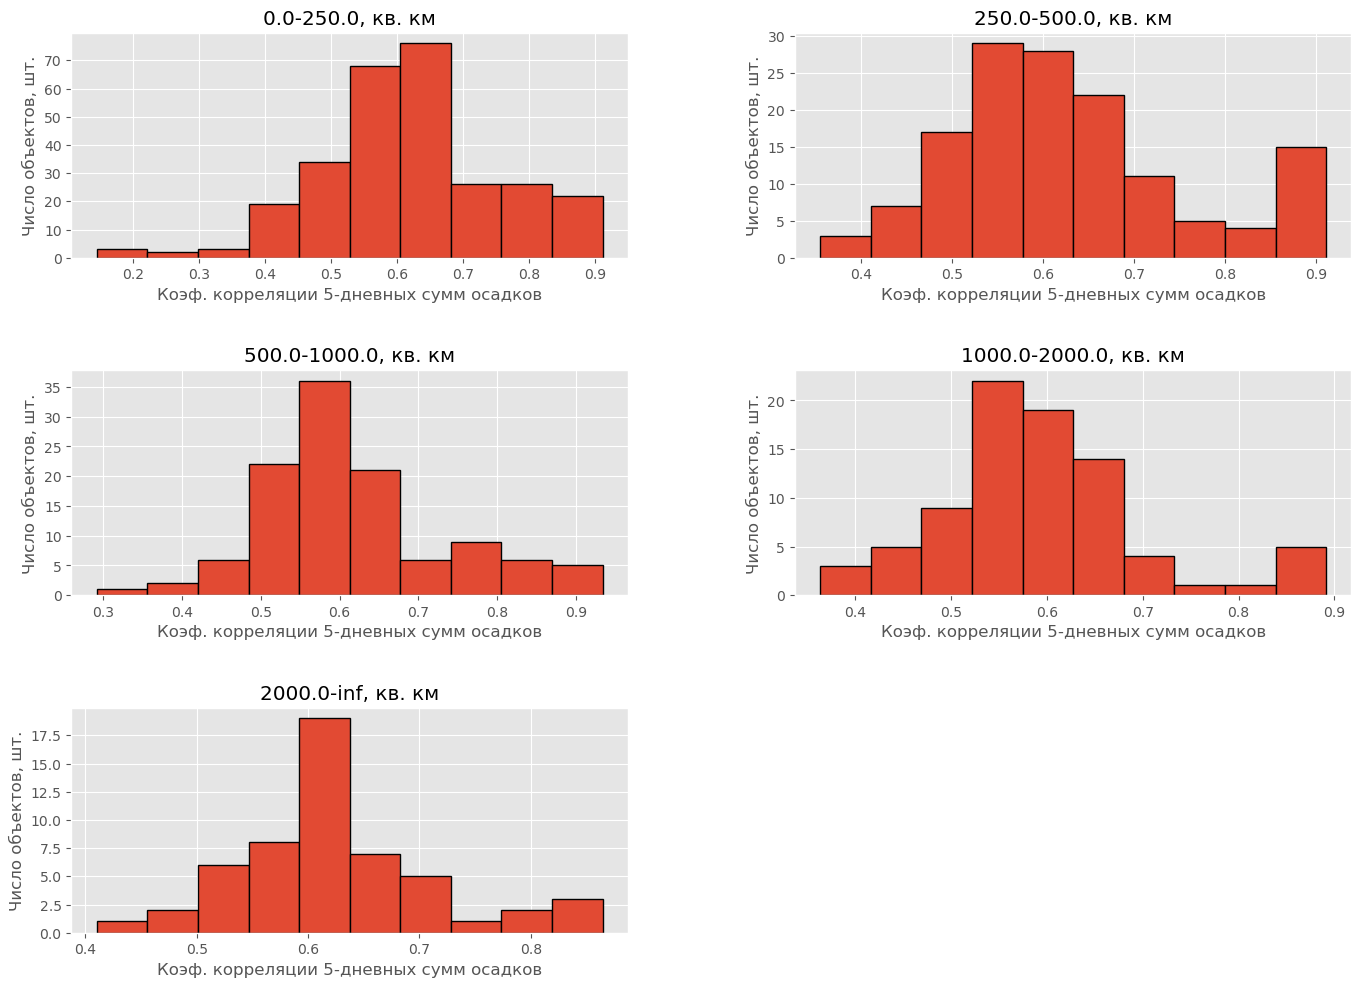

In [12]:
value_hist(column_to_plot='r2_5d',
           frequency='5d',
           xlabel="Коэф. корреляции 5-дневных сумм осадков")

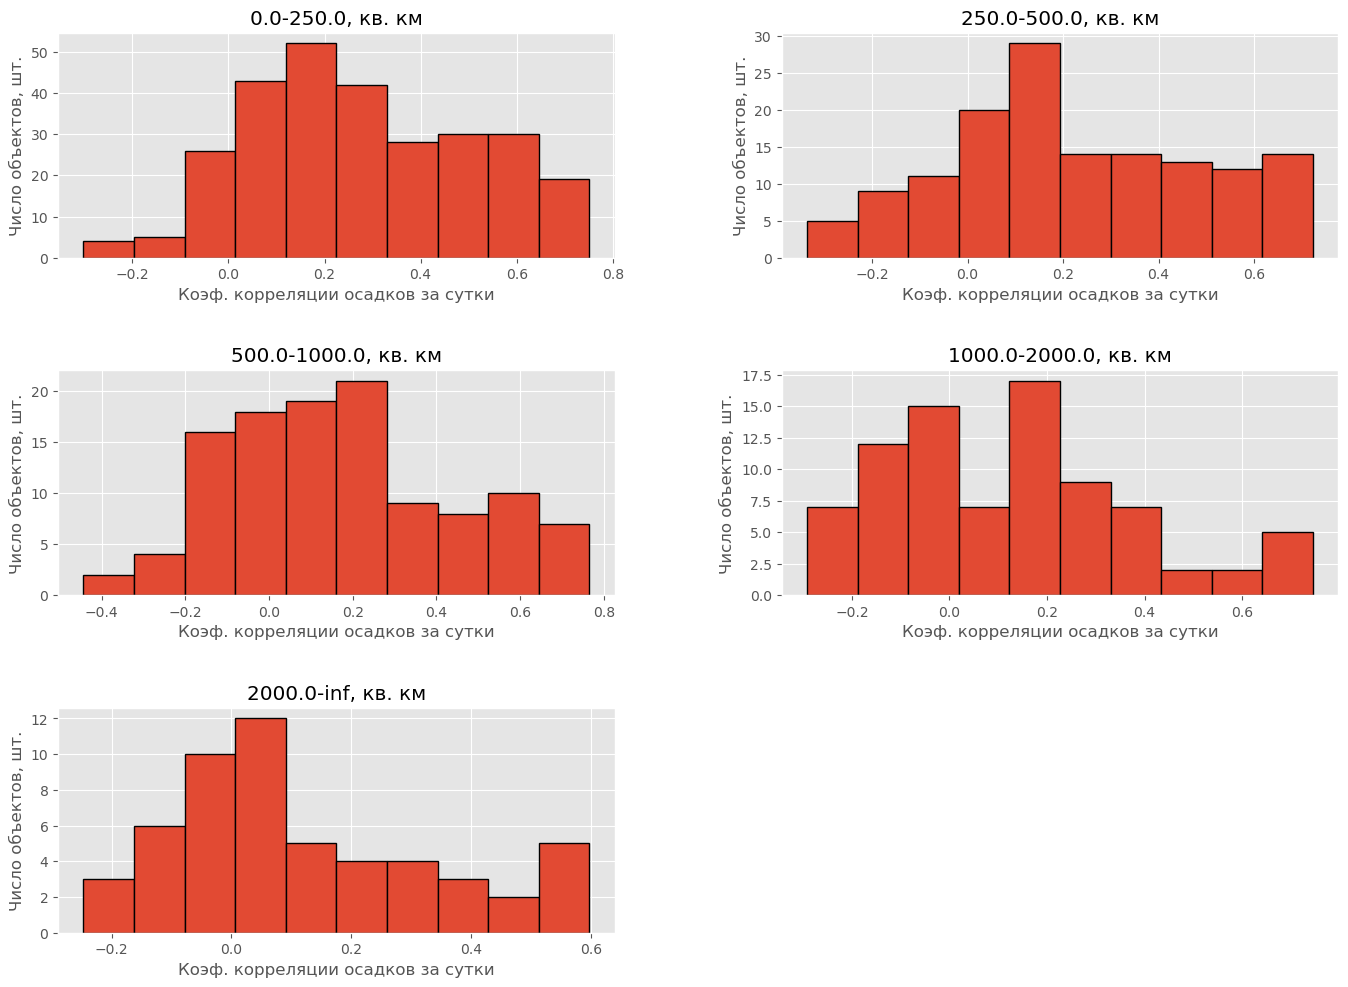

In [13]:
value_hist(column_to_plot='r2_daily',
           frequency='1d',
           xlabel="Коэф. корреляции осадков за сутки")